In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [72]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as sa
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [73]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [74]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [75]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [76]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [77]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [91]:
# Inspecting the precipitation table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date).first()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


('2010-01-01',)

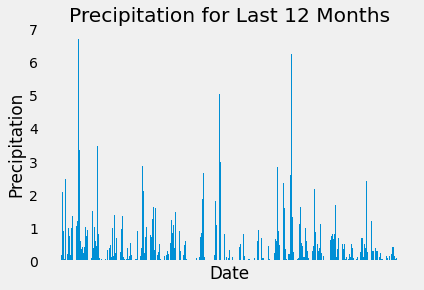

In [100]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

last_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
first_date = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
yearprep = session.query(measurement.date,measurement.prcp).\
    filter(measurement.date >= first_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(yearprep, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.dropna()
df = df.sort_values(by=['Date'])

date = df['Date'].to_list()
precipitation = df['Precipitation'].to_list()

# Use Pandas Plotting with Matplotlib to plot the data

df.set_index('Date', inplace=True)
plt.bar(date,precipitation)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 

plt.title(f"Precipitation for Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.show()


In [104]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [106]:
# Inspecting the precipitation table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

# Design a query to calculate the total number stations in the dataset
session.query(station.id).count()

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


9

In [115]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
measurecount = func.count(measurement.id)
measurestations = measurement.station
stations_measures = [measurestations,measurecount]
active_stations = session.query(*stations_measures).\
    group_by(measurestations).\
    order_by(measurecount.desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [119]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
measuretemp = measurement.tobs

tempcalc = [func.min(measuretemp),
            func.max(measuretemp),
            func.avg(measuretemp)]

topstation = session.query(*tempcalc).\
    group_by(measurestations).\
    order_by(measurecount.desc()).first()
topstation

(54.0, 85.0, 71.66378066378067)

Text(0.5, 1.0, 'Temperature from Last 12 Months at WAIHEE 837.5, HI US')

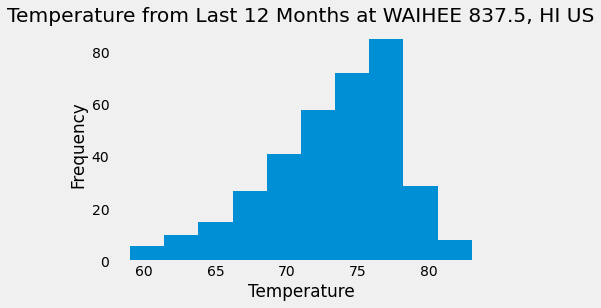

In [130]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
topstationdata = session.query(measuretemp).\
    filter(measurestations == active_stations[0][0]).\
    filter(measurement.date >= first_date).all()
temperatures = list(np.ravel(topstationdata))

station_list = [station.station,station.name,station.latitude,station.longitude,station.elevation]
topstationdata = session.query(*station_list).all()
station_df = pd.DataFrame(topstationdata, columns=['Station','Name','Latitude','Longitude','Elevation'])

station_name = station_df.loc[station_df["Station"] == active_stations[0][0],"Name"].tolist()[0]

# n, bins, patches = plt.hist(temperatures, bins=12,alpha=0.7, rwidth=1.0,label='tobs')
plt.hist(temperatures)
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title(f"Temperature from Last 12 Months at {station_name}")


# Close session

In [131]:
# Close Session
session.close()